# Radon Distribution in Northern Ireland - A Geological Perspective

This program has threefold

## List of libraries/packages used in this notebook
**pandas**: data analysis and manipulation tool. Info: https://pandas.pydata.org/

**geopandas**: enable working with geospatial data, allows spatial operations on geometric types. Info: https://geopandas.org/

**geoplot**: a geospatial plotting library. Source: https://residentmario.github.io/geoplot/index.html

**shapely**: for manipulation and analysis of planar geometric objects. Info: https://pypi.org/project/Shapely/

**matplotlib**: for creating static, animated, and interactive visualizations in Info. https://matplotlib.org/

**cartopy**: for drawing maps for data analysis and visualisation. Info: https://pypi.org/project/Cartopy/

**contextily**: to retrieve tile maps or basemaps from the internet. Info: https://contextily.readthedocs.io/en/latest/

**seaborn**: for drawing attractive and informative statistical graphics, based on matplotlib. Info: https://seaborn.pydata.org/

**rasterio**: provides access to geospatial raster data such as GeoTIFFs. Info: https://rasterio.readthedocs.io/en/latest/

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
## 1. Import the required libraries
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

The use of **%matplotlib notebook** below makes the plots interactive

In [1]:
%matplotlib notebook 

import pandas as pd
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
import cartopy as cp
from cartopy import config
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import contextily as ctx
import seaborn as sns
import rasterio as rio
import pydoc

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
## 2. Define figure formats and make plotting interactive
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

In [2]:
plt.rcParams.update({'font.size': 8}) # adjust the font size for the plots to be size 8


plt.ion() # make the plotting interactive

# generate matplotlib handles to create a legend of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870, answered by SO user Siyh: https://stackoverflow.com/a/35705477

def scale_bar(ax, location=(0.92, 0.95)):
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]

    tmc = ccrs.TransverseMercator(sbllx, sblly)
    x0, x1, y0, y1 = ax.get_extent(tmc)
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    plt.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=tmc)
    plt.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=tmc)
    plt.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=tmc)

    plt.text(sbx, sby-4500, '20 km', transform=tmc, fontsize=10)
    plt.text(sbx-12500, sby-4500, '10 km', transform=tmc, fontsize=10)
    plt.text(sbx-24500, sby-4500, '0 km', transform=tmc, fontsize=10)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
## 3. Read the datafiles
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

In [3]:
#Read radon data of the Northern Ireland
radon_table = pd.read_csv('data_files\RadonNI.csv')

""" read csv file """
# load the Counties shapefile
counties_orig = gpd.read_file('data_files/Counties.shp')

""" read shapefile """

# load the bedrock geology layer of Northern Ireland
bedrocks = gpd.read_file('data_files/NIbedrocks.shp')

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
## 4. RADON data
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

In [4]:
radon_table.shape # dispaly the data structure: 14720 rows and 4 columns

(14720, 4)

In [5]:
radon_table.info() # More information about the data: 14720 entries, position from 0 to 14719, arranged in 4 columns
                    # first column is object format, while the other three columns are in integer formats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14720 entries, 0 to 14719
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tile    14720 non-null  object
 1   class   14720 non-null  int64 
 2   x       14720 non-null  int64 
 3   y       14720 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 460.1+ KB


In [6]:
radon_table.head(10) #show the top 10 rows with the column headings

,Tile,class,x,y
0,D1053,1,310500,453500
1,D1153,1,311500,453500
2,D1253,1,312500,453500
3,D0952,2,309500,452500
4,D1052,2,310500,452500
5,D1152,2,311500,452500
6,D1252,2,312500,452500
7,D1352,2,313500,452500
8,D1452,2,314500,452500
9,D1552,1,315500,452500


In [7]:
# summary statistics of all the data
radon_table.describe()

,class,x,y
count,14720.000000,14720.000000,14720.000000
mean,2.682541,284638.111413,373938.383152
std,1.541938,41306.305800,32692.536830
min,1.000000,188500.000000,309500.000000
25%,1.000000,250500.000000,347500.000000
50%,2.000000,288500.000000,370500.000000
75%,4.000000,318500.000000,399500.000000
max,6.000000,366500.000000,453500.000000


In [8]:
radon_table["class"].describe() # Summary statistics of the radon data only. Radon classes ranges from 1 to 6.

count    14720.000000
mean         2.682541
std          1.541938
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max          6.000000
Name: class, dtype: float64

In [9]:
radon_table['class'].describe().round(0) # descriptive statistics of the radon classes, round numbers to nearest integer.

count    14720.0
mean         3.0
std          2.0
min          1.0
25%          1.0
50%          2.0
75%          4.0
max          6.0
Name: class, dtype: float64

<IPython.core.display.Javascript object>


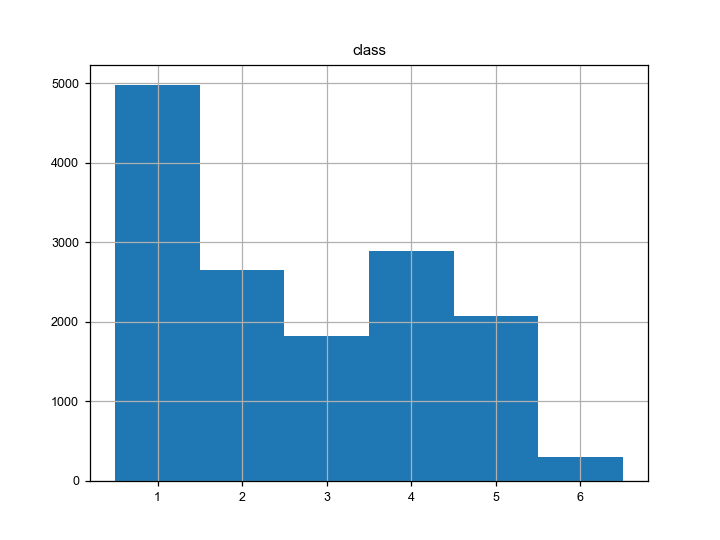

In [10]:
radon_table.hist(column='class', bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5]); # Histogram plot of the radon classes.
                                                                        # Class 1 is very common, followed by class 4.
                                                                        # Class 6 is rare.

## Radon Potential Classes and percentage bands

| Radon Potential Class | Nominal percentage band |

| 1 | 0-1 |

| 2 | 1-3 |

| 3 | 3-5 |

| 4 | 5-10 |

| 5 | 10-30 |

| 6 | 30-100 |

Nominal percentage band = Estimated percentage of dwellings exceeding the Radon Action Level

The **UK radon 'Action Level'** is 200 becquerels per cubic metre for the annual average of the radon gas concentration in a home. Radon classes above describe whether a property is in a radon Affected Area and the percentage of homes that are estimated to be at or above the radon Action Level. 

In conclusion, The higher the radon class, the higher risk of radon exposure. Class 1 indicates that 0 - 1 % of dwellings, in a specific area, are at risk of radon exposure higher than the UK normal radon level.

**The radon data provides an estimation, actual radon emission requires a radon measurement in an existing property**

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
## 5. Geospatial Analysis of the RADON data
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

C:\Users\asuwa\anaconda3\envs\RadonNI\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


<IPython.core.display.Javascript object>


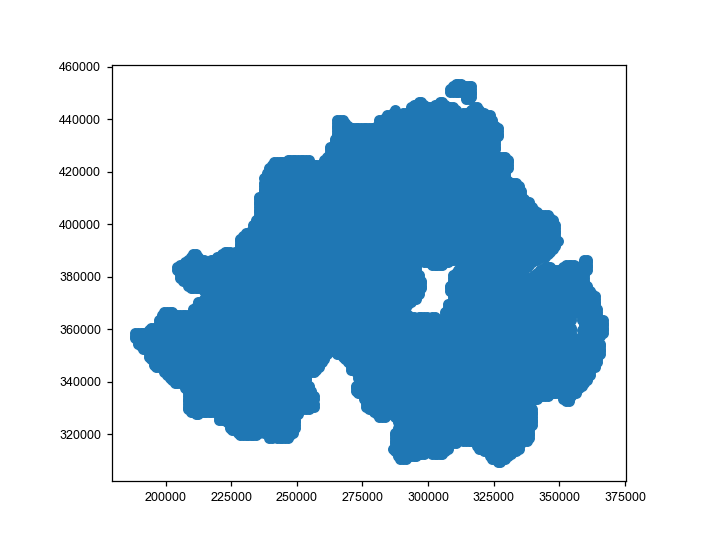

In [11]:
# set the coordinate type (to epsg:29902; i.e. TM65 / Irish Grid) and plot the radon data with respect to x, y
pts = [Point(row['x'], row['y']) for id, row in radon_table[['x', 'y']].iterrows()]

""" Assign the xy coordinates from the radon data """

pts = gpd.GeoSeries(pts, crs='+init=epsg:29902')

# plot the radon data with respect to their coordinates
pts.plot();

In [12]:
pts.crs # check the coordinate systems, i.e. check if the previous code worked!

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [13]:
# another way to assign the coordinate system (perhaps more simple)
radon_gdf = gpd.GeoDataFrame(radon_table, geometry=gpd.points_from_xy(radon_table.x, radon_table.y), crs='+init=epsg:29902')

C:\Users\asuwa\anaconda3\envs\RadonNI\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [14]:
radon_gdf.crs # check the coordinate system of the new dataset (radon_gdf)

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [15]:
radon_gdf.to_file('data_files/RadonNI.shp') # create a new shapefile of the radon data

In [16]:
radon = gpd.read_file('data_files/RadonNI.shp') # load the radon shapefile

<IPython.core.display.Javascript object>


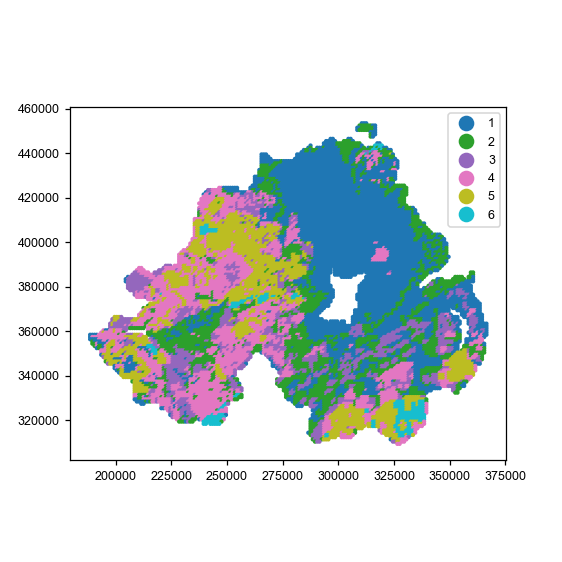

In [17]:
# Display the radon distribution, symbology is based on the "class" attribute/column.
fig, ax = plt.subplots(figsize=(5, 5))

""" Design the plot """

radon.plot(column='class',
                categorical=True,
                legend=True,
                ax=ax,
                  markersize=3)

""" identify the column to plot and add legend """

# Adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1,1))

# Add map frames/axes
ax.set_axis_on()

plt.show()

Note the class distribution above. Class 1 is dominant, especially in the nothern and eastern parts of Northern Ireland, while class 4 is very common in the western parts. Cluster distribution is mostly patchy. In the southeastern area, the classes seems to follow a linear pattern with a general NE - SW drection. 

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
## 6. Radon potential level in various counties
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

In [18]:
counties_orig.shape # Table of attributes of the "counties" shapefile is made up of 6 rows (6 counties) and five columns

(6, 5)

In [19]:
counties_orig.columns # read the column headings

Index(['COUNTY_ID', 'CountyName', 'Area_SqKM', 'OBJECTID', 'geometry'], dtype='object')

In [20]:
divisions = counties_orig['CountyName'].tolist() # Get a list of a the counties; 6 counties
print(divisions)

['TYRONE', 'ANTRIM', 'ARMAGH', 'FERMANAGH', 'LONDONDERRY', 'DOWN']


In [21]:
# display the data. 

counties_orig.head()

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,geometry
0,6,TYRONE,3265.796622,1,"POLYGON ((-7.38177 54.94208, -7.38170 54.94201..."
1,1,ANTRIM,3097.847750,2,"MULTIPOLYGON (((-5.95296 54.55222, -5.95298 54..."
2,2,ARMAGH,1327.228438,3,"POLYGON ((-6.35398 54.50927, -6.35191 54.50891..."
3,4,FERMANAGH,1850.832538,4,"POLYGON ((-7.69417 54.60511, -7.69390 54.60498..."
4,5,LONDONDERRY,2118.316853,5,"POLYGON ((-6.66919 55.19899, -6.66918 55.19893..."


Note that each county is represented by one polygon while county Antrim is represnted by more than one polygon (multipolygon)

County Antrim occupies part of the mainland and the Rathlin iseland in the north, hence is presented by two polygons

![Cat](data_files/County_Antrim.png)


In [22]:
# sort the counties according to their area (in km2), starting with the largest.
counties_orig.groupby("CountyName").mean().sort_values(by = "Area_SqKM", ascending = False)

,COUNTY_ID,Area_SqKM,OBJECTID
CountyName,,,
TYRONE,6,3265.796622,1
ANTRIM,1,3097.847750,2
DOWN,3,2491.238606,6
LONDONDERRY,5,2118.316853,5
FERMANAGH,4,1850.832538,4
ARMAGH,2,1327.228438,3


Note that County Tyrone is the largest in area.

<IPython.core.display.Javascript object>


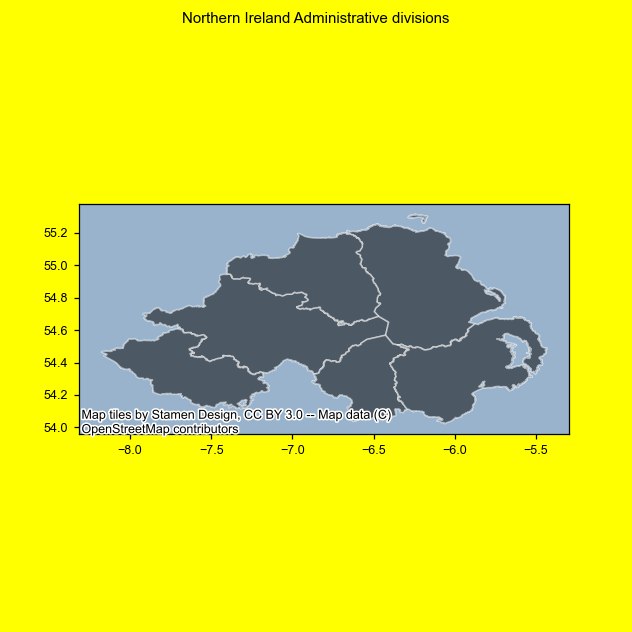

C:\Users\asuwa\anaconda3\envs\RadonNI\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 26 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


In [23]:
# to show a basemap background
f, ax = plt.subplots(1, figsize=(5, 5), edgecolor="blue", facecolor="yellow")
counties_orig.plot(color='k', alpha=0.5, ax=ax)
ctx.add_basemap(ax)
plt.show('CountyName')
f.suptitle('Northern Ireland Administrative divisions')
plt.show()

In [24]:
counties_orig.crs # check the coordinate system of the counties shapefile, it is EPSG:4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
counties = counties_orig.to_crs(epsg=29902) # change the CRS to epsg=29902, to match the radon data coordinates

In [26]:
# check the coordinates again
counties.crs

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

<IPython.core.display.Javascript object>


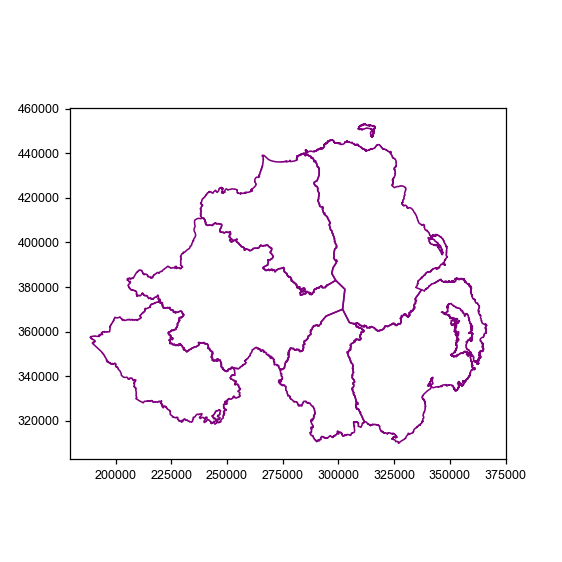

In [27]:
# Plot the counties again. Note the difference in the coordinates numbers compared to code 23.
# Note here that we used "edgecolor" and "facecolor" to manipulate the appearance of the polygons
counties.plot(figsize=(5,5), edgecolor="purple", facecolor="None"); # plot the counties in the Northern Ireland

<IPython.core.display.Javascript object>


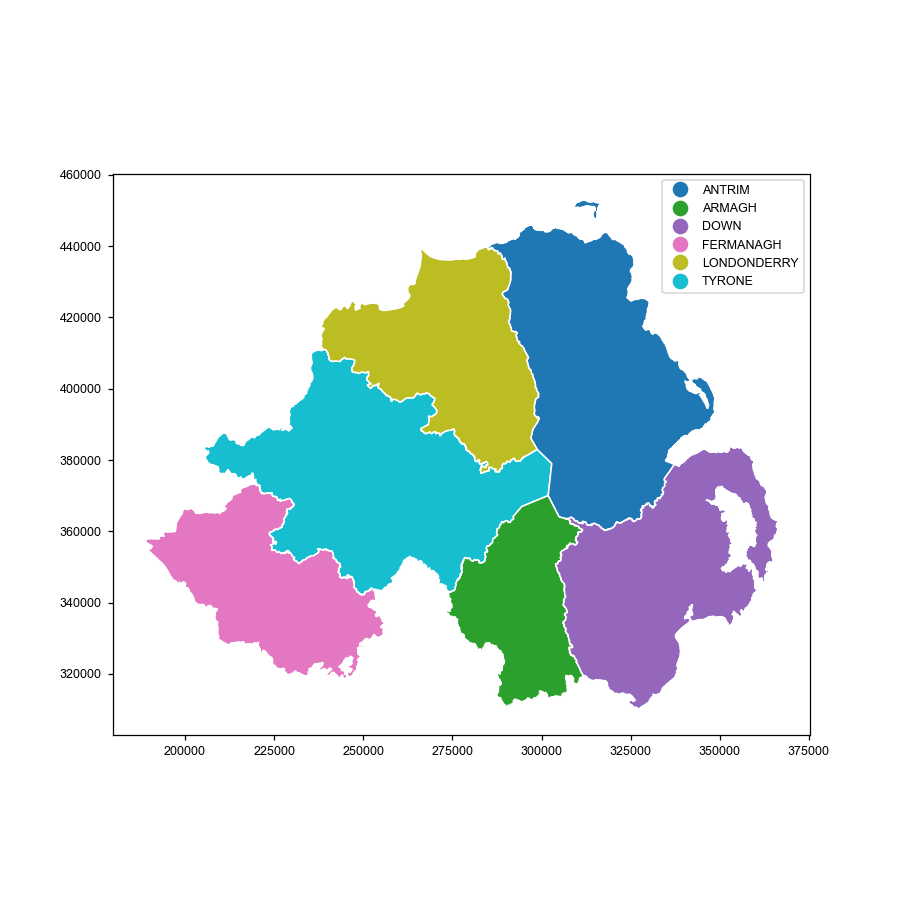

In [28]:
# Plot the counties, symbology follows the county name (attribute "CountyName")
counties.plot('CountyName', legend=True, figsize=(8, 8)); 

In [29]:
print(radon.crs == counties.crs) # check if the CRS of the radon and counties data are the same

True


In [30]:
#join (spatial join) the radon and counties data
radon_counties = gpd.sjoin(counties, radon, how='inner', lsuffix='left', rsuffix='right')  # join the two datasets into one

In [31]:
radon_counties # display the new dataset, point datasets combining the radon and the county where each point is located

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,geometry,index_right,Tile,class,x,y
0,6,TYRONE,3265.796622,1,"POLYGON ((239669.128 410673.862, 239674.096 41...",11267,H7546,4,275500,346500
0,6,TYRONE,3265.796622,1,"POLYGON ((239669.128 410673.862, 239674.096 41...",11268,H7646,3,276500,346500
0,6,TYRONE,3265.796622,1,"POLYGON ((239669.128 410673.862, 239674.096 41...",11109,H7647,2,276500,347500
0,6,TYRONE,3265.796622,1,"POLYGON ((239669.128 410673.862, 239674.096 41...",11723,H7343,3,273500,343500
0,6,TYRONE,3265.796622,1,"POLYGON ((239669.128 410673.862, 239674.096 41...",11724,H7443,3,274500,343500
...,...,...,...,...,...,...,...,...,...,...
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((325844.568 312608.674, 325840....",8630,J2662,1,326500,362500
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((325844.568 312608.674, 325840....",8631,J2762,1,327500,362500
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((325844.568 312608.674, 325840....",8612,J0862,3,308500,362500
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((325844.568 312608.674, 325840....",8445,J0863,1,308500,363500


In [32]:
radon_counties.shape # structure of the new dataset; 13855 rows and 10 columns

(13855, 10)

In [33]:
radon_counties.info() #type of data within the new dataset

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13855 entries, 0 to 5
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   COUNTY_ID    13855 non-null  int64   
 1   CountyName   13855 non-null  object  
 2   Area_SqKM    13855 non-null  float64 
 3   OBJECTID     13855 non-null  int64   
 4   geometry     13855 non-null  geometry
 5   index_right  13855 non-null  int64   
 6   Tile         13855 non-null  object  
 7   class        13855 non-null  int64   
 8   x            13855 non-null  int64   
 9   y            13855 non-null  int64   
dtypes: float64(1), geometry(1), int64(6), object(2)
memory usage: 1.2+ MB


<IPython.core.display.Javascript object>


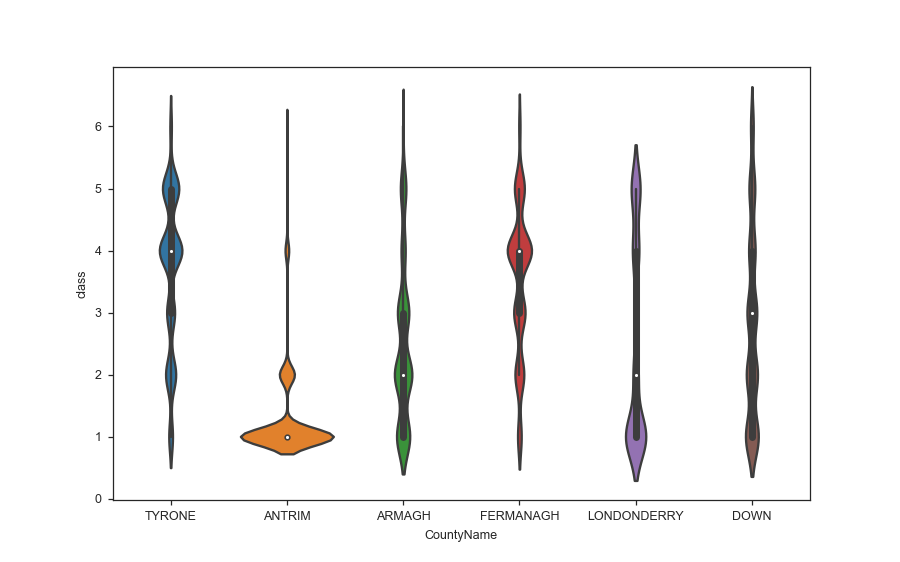

In [34]:
# Distribution of various classes within the counties. 
# Each county contian the 6 radon classess, except County LONDONDERRY where class 6 is absent.
# Note that we are using Seaborn package
# code is adapted from: https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot

sns.set_style('ticks')
fig, ax = plt.subplots()

# set the size of the graph
fig.set_size_inches(8, 5)
sns.violinplot(x = "CountyName", y = "class", data = radon_counties)

#save the figure as an image
fig.savefig('data_files/Radon_classes_Counties.png')

Some notes to help you understanding the Violin plot (source: https://mode.com/blog/violin-plot-examples/)

Violin plots are quite similar to box plots. The white dots above represents the median while the thick grey bar in the centers represent the interquartile range. The thin gray line represents the rest of the distribution.
Wider sections of the violin plot represent a higher probability that members of the population will take on the given value; the skinnier sections represent a lower probability.
At County Tyrone, the median of radon potetial level lies around class 4 and considered the highest among the counties.

![Cat](data_files/ViolinPlot_explained.png)

In [35]:
# assign the CRS to the new dataset (joined radon - counties dataset)

radon_counties_gdf = gpd.GeoDataFrame(radon_counties, geometry=gpd.points_from_xy(radon_counties.x, radon_counties.y), crs='+init=epsg:29902')

C:\Users\asuwa\anaconda3\envs\RadonNI\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [36]:
radon_counties_gdf.crs # check the CRS

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [37]:
# create a new shapefile combining the radon and the counties data
radon_counties_gdf.to_file('data_files/radon_counties.shp') 

<ipython-input-37-8f34627e6942>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  radon_counties_gdf.to_file('data_files/radon_counties.shp')


In [38]:
# load the new shapefile 
radon_counties = gpd.read_file('data_files/radon_counties.shp') # load the radon_counties shapefile

In [39]:
# show a brief description of the new shapefile. County Tyrone is the largest in data count
radon_counties.CountyName.describe()

count      13855
unique         6
top       TYRONE
freq        3184
Name: CountyName, dtype: object

In [40]:
radon_counties  # display the attributes of the new shapefile

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,index_righ,Tile,class,x,y,geometry
0,6,TYRONE,3265.796622,1,11267,H7546,4,275500,346500,POINT (275500.000 346500.000)
1,6,TYRONE,3265.796622,1,11268,H7646,3,276500,346500,POINT (276500.000 346500.000)
2,6,TYRONE,3265.796622,1,11109,H7647,2,276500,347500,POINT (276500.000 347500.000)
3,6,TYRONE,3265.796622,1,11723,H7343,3,273500,343500,POINT (273500.000 343500.000)
4,6,TYRONE,3265.796622,1,11724,H7443,3,274500,343500,POINT (274500.000 343500.000)
...,...,...,...,...,...,...,...,...,...,...
13850,3,DOWN,2491.238606,6,8630,J2662,1,326500,362500,POINT (326500.000 362500.000)
13851,3,DOWN,2491.238606,6,8631,J2762,1,327500,362500,POINT (327500.000 362500.000)
13852,3,DOWN,2491.238606,6,8612,J0862,3,308500,362500,POINT (308500.000 362500.000)
13853,3,DOWN,2491.238606,6,8445,J0863,1,308500,363500,POINT (308500.000 363500.000)


In [41]:
# display the data counts of each class
radon_counties.groupby(['class']).count() 

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,index_righ,Tile,x,y,geometry
class,,,,,,,,,
1,4699,4699,4699,4699,4699,4699,4699,4699,4699
2,2431,2431,2431,2431,2431,2431,2431,2431,2431
3,1721,1721,1721,1721,1721,1721,1721,1721,1721
4,2734,2734,2734,2734,2734,2734,2734,2734,2734
5,2002,2002,2002,2002,2002,2002,2002,2002,2002
6,268,268,268,268,268,268,268,268,268


<IPython.core.display.Javascript object>


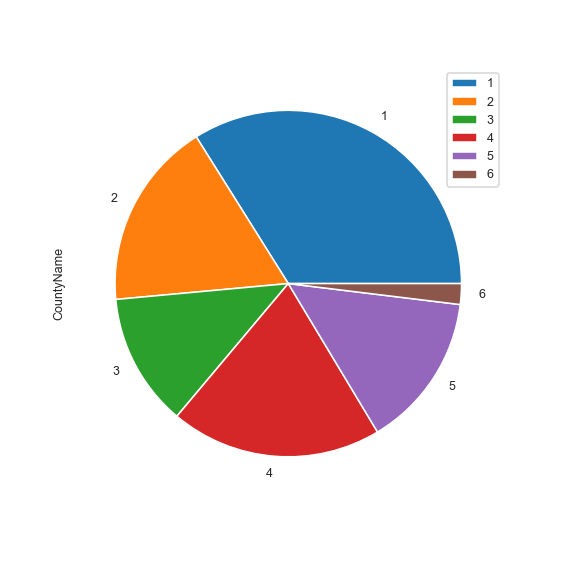

In [42]:
# Pie plot of each class count in the Northern Ireland. Class 1 is the top while class 6 is the lowest
radon_counties.groupby(['class']).count().plot(kind='pie', y='CountyName', figsize=(5, 5));

In [43]:
# summarize the radon distribution within each County. 
print(radon_counties.groupby(['CountyName', 'class'])['class'].count()) 

CountyName   class
ANTRIM       1        2448
             2         397
             3           7
             4          96
             5           1
             6          11
ARMAGH       1         327
             2         434
             3         283
             4         103
             5         138
             6           3
DOWN         1         656
             2         568
             3         501
             4         331
             5         300
             6         139
FERMANAGH    1         113
             2         273
             3         349
             4         745
             5         305
             6          39
LONDONDERRY  1         964
             2         241
             3         174
             4         303
             5         422
TYRONE       1         191
             2         518
             3         407
             4        1156
             5         836
             6          76
Name: class, dtype: int64


In [44]:
# Average radon class in each county
radon_counties.groupby("CountyName")["class"].mean()  

CountyName
ANTRIM         1.256081
ARMAGH         2.456522
DOWN           2.786774
FERMANAGH      3.533443
LONDONDERRY    2.514259
TYRONE         3.677136
Name: class, dtype: float64

In [45]:
# Average radon class in each county, sorted by the highest. 
# County Tyrone shows the highest radon potential level, with an average of 3.68
radon_counties.groupby("CountyName").mean().sort_values(by = "class", ascending = False) 

,COUNTY_ID,Area_SqKM,OBJECTID,index_righ,class,x,y
CountyName,,,,,,,
TYRONE,6.0,3265.796622,1.0,7004.829774,3.677136,253130.025126,374022.613065
FERMANAGH,4.0,1850.832538,4.0,11370.660636,3.533443,223566.885965,344410.635965
DOWN,3.0,2491.238606,6.0,10890.040481,2.786774,333823.046092,347807.815631
LONDONDERRY,5.0,2118.316853,5.0,2655.370722,2.514259,273890.209125,409728.136882
ARMAGH,2.0,1327.228438,3.0,12102.815217,2.456522,294173.913043,339005.434783
ANTRIM,1.0,3097.847750,2.0,3355.223986,1.256081,316042.567568,405103.378378


Note that County Tyrone is the largest in area, also display the highest average radon potential risk.

Hence, we will focus on this county for a bit of time to understand the radon distribution in this specific county

In [46]:
# subset the data, i.e. create a new dataset representing the radon distribution in the County Tyrone
county_tyrone = radon_counties[radon_counties.CountyName == "TYRONE"]
len(county_tyrone) # returns the number of radon data (data count) in county Tyrone

3184

In [47]:
county_tyrone # display the Tyrone dataset

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,index_righ,Tile,class,x,y,geometry
0,6,TYRONE,3265.796622,1,11267,H7546,4,275500,346500,POINT (275500.000 346500.000)
1,6,TYRONE,3265.796622,1,11268,H7646,3,276500,346500,POINT (276500.000 346500.000)
2,6,TYRONE,3265.796622,1,11109,H7647,2,276500,347500,POINT (276500.000 347500.000)
3,6,TYRONE,3265.796622,1,11723,H7343,3,273500,343500,POINT (273500.000 343500.000)
4,6,TYRONE,3265.796622,1,11724,H7443,3,274500,343500,POINT (274500.000 343500.000)
...,...,...,...,...,...,...,...,...,...,...
3179,6,TYRONE,3265.796622,1,2414,C3910,4,239500,410500,POINT (239500.000 410500.000)
3180,6,TYRONE,3265.796622,1,2411,C3610,4,236500,410500,POINT (236500.000 410500.000)
3181,6,TYRONE,3265.796622,1,2412,C3710,4,237500,410500,POINT (237500.000 410500.000)
3182,6,TYRONE,3265.796622,1,2725,C4307,5,243500,407500,POINT (243500.000 407500.000)


In [48]:
# show the maximum and minimum class values in County Tyrone
county_tyrone.loc[[county_tyrone["class"].idxmax(), county_tyrone["class"].idxmin()]]

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,index_righ,Tile,class,x,y,geometry
413,6,TYRONE,3265.796622,1,6873,H8474,6,284500,374500,POINT (284500.000 374500.000)
81,6,TYRONE,3265.796622,1,10280,H7952,1,279500,352500,POINT (279500.000 352500.000)


<IPython.core.display.Javascript object>


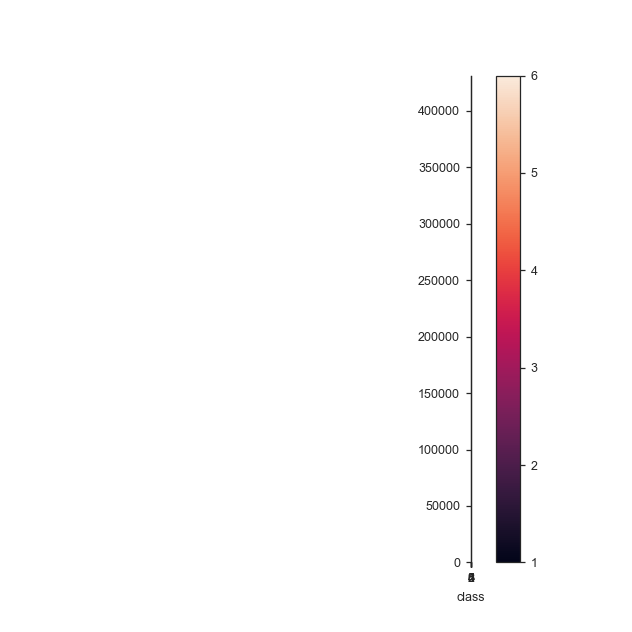

In [49]:
# plot the radon distribution in County Tyrone. 
# Higher radon classes in the northern parts of the county compared to the southern parts.
county_tyrone.plot(column='class', cmap=None, legend=True, figsize=(5, 5)); 

In [50]:
# calculate the class percentages. Note that total data count is = 3184
tyrone_class_percent = (county_tyrone.groupby(['class'])['class'].count() * 100 / 3184) 
tyrone_class_percent

class
1     5.998744
2    16.268844
3    12.782663
4    36.306533
5    26.256281
6     2.386935
Name: class, dtype: float64

In [51]:
# plot the classes. Note that Class 4 is the highest in the county
ax = tyrone_class_percent.plot.bar(x='class', y='%', rot=0)

In [52]:
county_tyrone.crs #check CRS

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [53]:
# save Tyron data to a new shapefile
county_tyrone.to_file('data_files/radon_tyrone.shp') 

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
## 7. Bedrock Geology
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

In [54]:
bedrocks.shape # datasets are made up of 2263 rows (records) and 5 columns (attributes)

(2263, 5)

In [55]:
# Read the bedrocks dataset
bedrocks

,MSLINK_0,UnitName,Code,area,geometry
0,3678,ACID VOLCANICS,5,4.171498e+05,"POLYGON ((306027.195 353143.694, 306147.747 35..."
1,3678,ACID VOLCANICS,5,8.885223e+05,"POLYGON ((305968.411 353228.661, 306164.238 35..."
2,3659,ACID VOLCANICS,5,5.596615e+04,"POLYGON ((313527.461 407868.052, 313589.811 40..."
3,3663,ACID VOLCANICS,5,9.072705e+04,"POLYGON ((325888.569 386805.060, 325974.534 38..."
4,3659,ACID VOLCANICS,5,1.247527e+05,"POLYGON ((311478.844 406950.057, 311603.542 40..."
...,...,...,...,...,...
2258,3602,SANDSTONE,8,1.299333e+08,"POLYGON ((275379.821 345384.076, 275448.622 34..."
2259,3689,SANDSTONE,8,2.949386e+05,"POLYGON ((344783.212 372882.594, 344956.610 37..."
2260,3581,SANDSTONE,8,3.032128e+05,"POLYGON ((310257.133 438486.495, 310370.824 43..."
2261,0,SANDSTONE,8,1.311301e+01,"POLYGON ((262865.226 428766.507, 262868.173 42..."


In [56]:
# view the number of bedrock types
bedrocks['UnitName'].describe()

count          2263
unique           11
top       LIMESTONE
freq            492
Name: UnitName, dtype: object

<IPython.core.display.Javascript object>


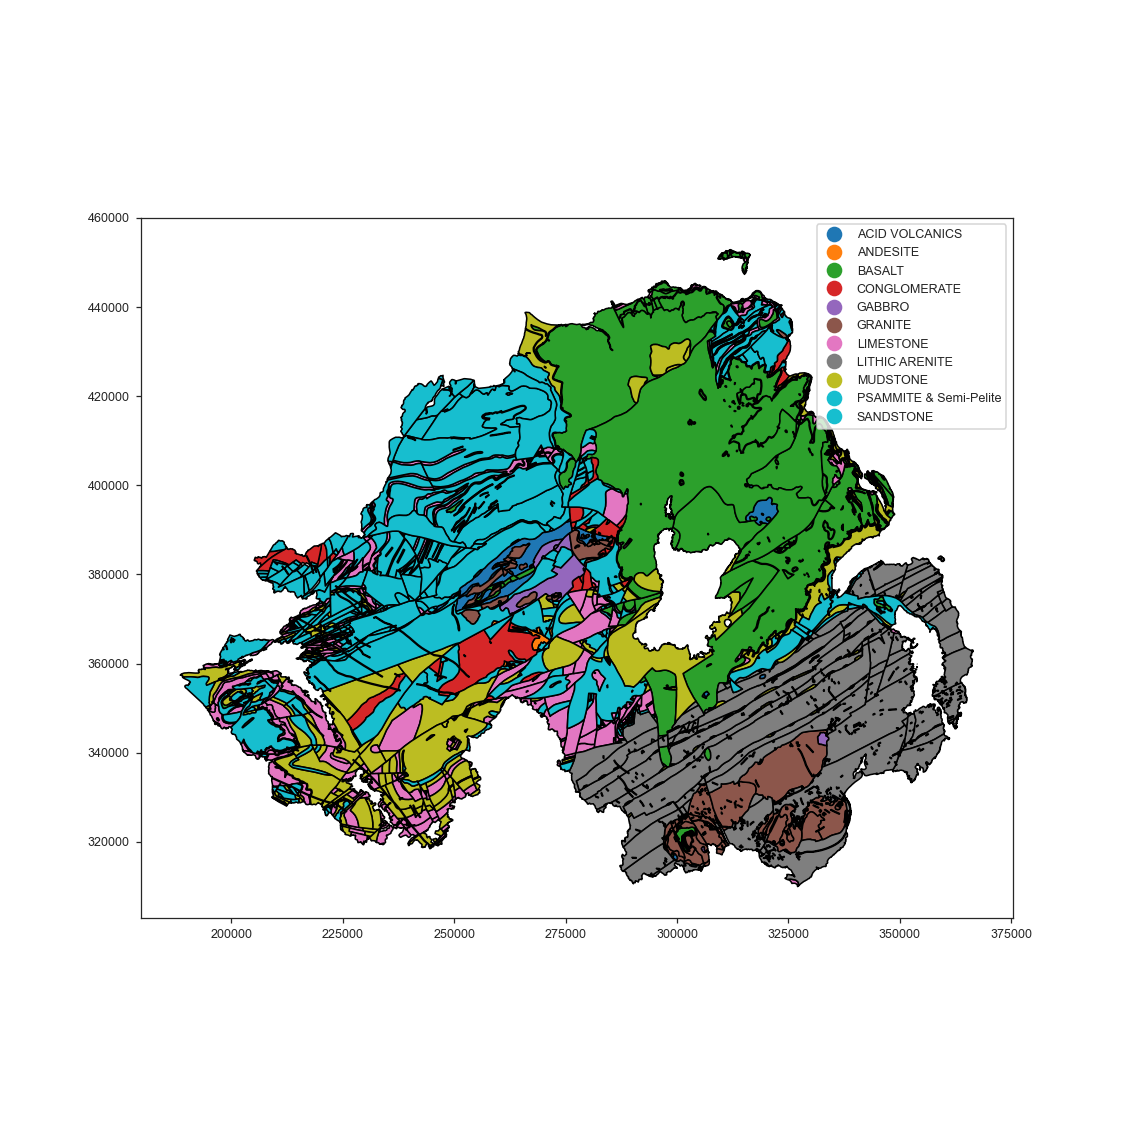

<AxesSubplot:>

In [57]:
# Plot the bedrock dataset with symbology and legend
bedrocks.plot(column='UnitName', edgecolor="black", cmap=None, legend=True, figsize=(10, 10))

Note that the basalt (green colour) occupies most of the northeastern part of the area, while lithic arenites (grey colour),a type of sandstones, is dominant in the southeastern parts. The western part of the country is represented by complex distribution of various rocks. Granites bodies can be observed in various parts of the maps but form large pluton in the southeast.

In [58]:
bedrocks.crs # check coordinates

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [59]:
# show the number of polygons representing each bedrock type
bedrocks['UnitName'].value_counts() 

LIMESTONE                 492
MUDSTONE                  490
SANDSTONE                 346
BASALT                    343
GRANITE                   184
LITHIC ARENITE            174
PSAMMITE & Semi-Pelite    139
CONGLOMERATE               41
ACID VOLCANICS             24
ANDESITE                   18
GABBRO                     12
Name: UnitName, dtype: int64

In [60]:
# Total area of each lithology in km2. Note that basalt covers the largest area
print(bedrocks.groupby(by=["UnitName"])["area"].sum() /1000000)

UnitName
ACID VOLCANICS             163.646183
ANDESITE                    20.114958
BASALT                    3419.777337
CONGLOMERATE               341.487118
GABBRO                     100.330584
GRANITE                    624.382891
LIMESTONE                 1108.611318
LITHIC ARENITE            2462.508416
MUDSTONE                  1584.046536
PSAMMITE & Semi-Pelite    1764.213243
SANDSTONE                 1869.394440
Name: area, dtype: float64


In [61]:
# join the radon and bedrock datasets
radon_bedrocks = gpd.sjoin(bedrocks, radon, how='inner', lsuffix='left', rsuffix='right')  

In [62]:
radon_bedrocks.to_file('data_files/radon_bedrock.shp')

<ipython-input-62-6d50c6824d40>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  radon_bedrocks.to_file('data_files/radon_bedrock.shp')


In [63]:
# read the new dataset
radon_bedrocks

,MSLINK_0,UnitName,Code,area,geometry,index_right,Tile,class,x,y
1,3678,ACID VOLCANICS,5,8.885223e+05,"POLYGON ((305968.411 353228.661, 306164.238 35...",10134,J0653,4,306500,353500
1,3678,ACID VOLCANICS,5,8.885223e+05,"POLYGON ((305968.411 353228.661, 306164.238 35...",10307,J0652,1,306500,352500
3,3663,ACID VOLCANICS,5,9.072705e+04,"POLYGON ((325888.569 386805.060, 325974.534 38...",5275,J2586,1,325500,386500
4,3659,ACID VOLCANICS,5,1.247527e+05,"POLYGON ((311478.844 406950.057, 311603.542 40...",2897,D1106,1,311500,406500
9,3659,ACID VOLCANICS,5,9.223958e+05,"POLYGON ((319385.996 357532.585, 319634.394 35...",9453,J1957,1,319500,357500
...,...,...,...,...,...,...,...,...,...,...
2258,3602,SANDSTONE,8,1.299333e+08,"POLYGON ((275379.821 345384.076, 275448.622 34...",9413,H7957,2,279500,357500
2258,3602,SANDSTONE,8,1.299333e+08,"POLYGON ((275379.821 345384.076, 275448.622 34...",9241,H8058,2,280500,358500
2258,3602,SANDSTONE,8,1.299333e+08,"POLYGON ((275379.821 345384.076, 275448.622 34...",8908,H8160,2,281500,360500
2258,3602,SANDSTONE,8,1.299333e+08,"POLYGON ((275379.821 345384.076, 275448.622 34...",8907,H8060,2,280500,360500


<IPython.core.display.Javascript object>


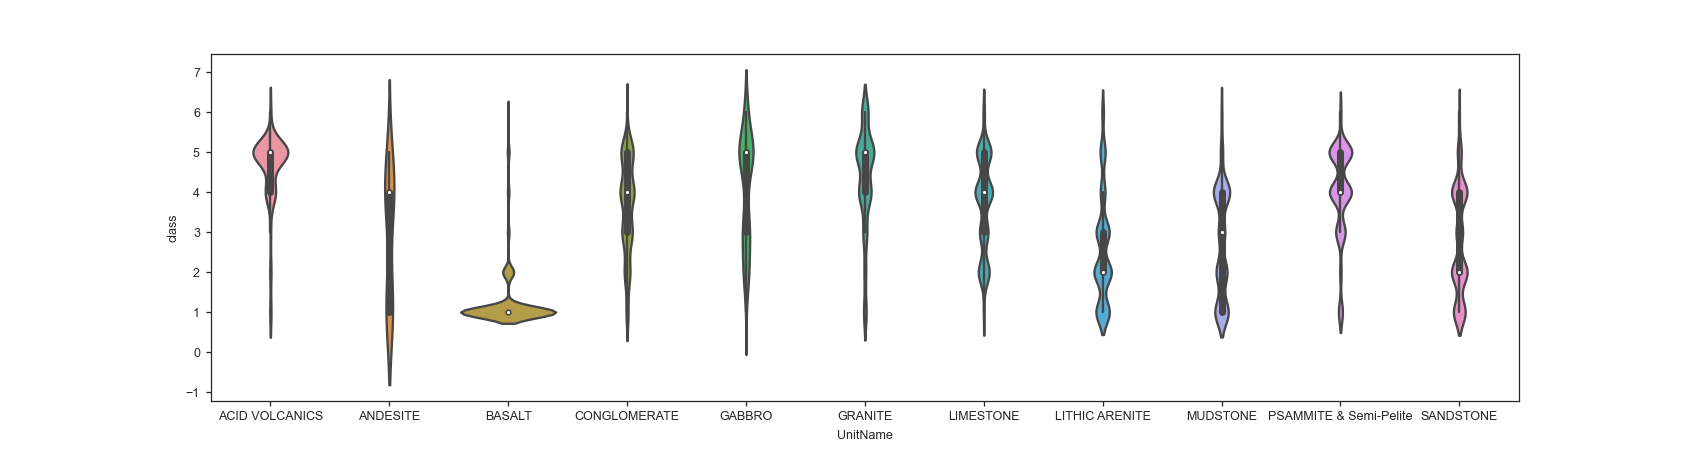

In [64]:
# distribution of various classes within each bedrock type. 
# code adapted from: https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
sns.set_style('ticks')
fig, ax = plt.subplots()

# set the size of the graph
fig.set_size_inches(15, 4)

sns.violinplot(x = "UnitName", y = "class", data = radon_bedrocks)

#save the figure as an image
fig.savefig('data_files/radon_bedrocks.png')

Bedrocks classed as acid volcanics, granites and gabbros show show the highest median values and the highest probabilities of high radon classes. In the meantime, basalt bedrock are more likely to be associated with the lowest radon levels.

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
## 8. Digital Terrain Model Data
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

In [65]:
# Open the raster and store metadata
dtm = rio.open('data_files/ni_dtm.tif')

In [66]:
#View raster information
print('{} opened in {} mode'.format(dtm.name,dtm.mode))
print('image has {} band(s)'.format(dtm.count))
print('image size (width, height): {} x {}'.format(dtm.width, dtm.height))
print('band 1 dataype is {}'.format(dtm.dtypes[0])) # note that the band name (Band 1) differs from the list index [0]

data_files/ni_dtm.tif opened in r mode
image has 1 band(s)
image size (width, height): 3559 x 2867
band 1 dataype is int16


In [67]:
print(dtm.bounds)

BoundingBox(left=188566.06416642142, bottom=309840.37988014915, right=366516.0641664214, top=453190.37988014915)


In [68]:
print(dtm.crs)

EPSG:29902


In [69]:
# Read points from shapefile
pts = radon
pts = pts[['x', 'y', 'class', 'geometry']]
pts.index = range(len(pts))
coords = [(x,y) for x, y in zip(pts.x, pts.y)]

# Sample the raster at every point location and store values in DataFrame
# adapted after: https://gis.stackexchange.com/questions/345428/reading-raster-values-in-points-gives-back-a-generator-object-instead-of-actual
pts['Value'] = [x[0] for x in dtm.sample(coords)]

In [70]:
# pairing the xy with the geometry
zip(pts.geometry.x, pts.geometry.y)

In [71]:
# show the raster values (elevation in m)
pts['Value']

0          0
1          0
2          0
3          0
4          0
        ... 
14715    122
14716      0
14717      0
14718      0
14719      0
Name: Value, Length: 14720, dtype: int64

In [72]:
pts.crs #  show the coordinates of the dataset

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [73]:
# create a new shapefile of the radon and elevation data
pts.to_file('data_files/radon_dtm.shp')

In [74]:
# load the shapefile
radon_dtm = gpd.read_file('data_files/radon_dtm.shp')

<IPython.core.display.Javascript object>


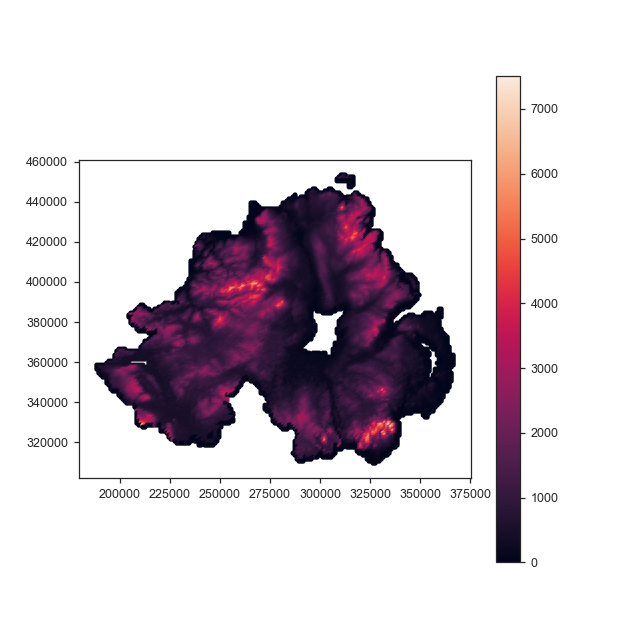

In [75]:
# Show the elevation distribution
radon_dtm.plot('Value', legend=True, figsize=(5, 5), markersize=5);

In [76]:
# show the dataset
radon_dtm

,x,y,class,Value,geometry
0,310500,453500,1,0,POINT (310500.000 453500.000)
1,311500,453500,1,0,POINT (311500.000 453500.000)
2,312500,453500,1,0,POINT (312500.000 453500.000)
3,309500,452500,2,0,POINT (309500.000 452500.000)
4,310500,452500,2,0,POINT (310500.000 452500.000)
...,...,...,...,...,...
14715,327500,310500,5,122,POINT (327500.000 310500.000)
14716,328500,310500,4,0,POINT (328500.000 310500.000)
14717,329500,310500,4,0,POINT (329500.000 310500.000)
14718,326500,309500,4,0,POINT (326500.000 309500.000)


<IPython.core.display.Javascript object>


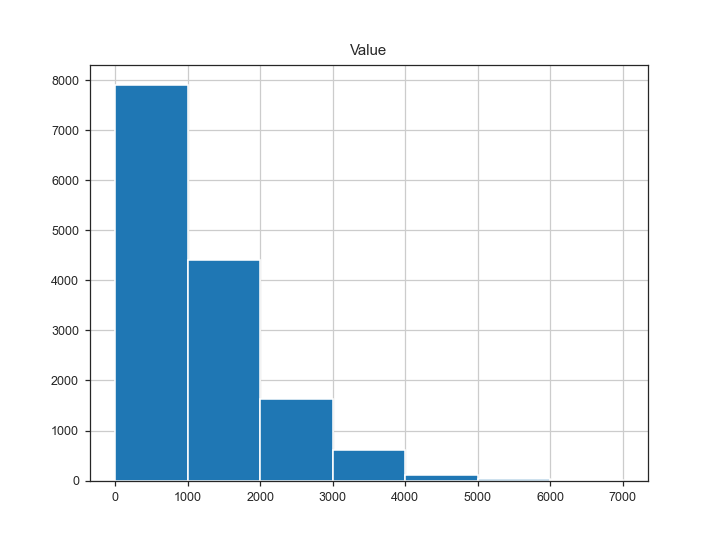

In [77]:
# histogram of elevation data
radon_dtm.hist(column='Value', bins=[0,1000,2000,3000,4000,5000,6000,7000]);

In [78]:
# Show the average ground elevation corresponding to each radon class
DTM_mean=radon_dtm.groupby("class").mean().sort_values(by = "Value", ascending = False)
DTM_mean

,x,y,Value
class,,,
5,265557.294174,368956.427540,1603.001926
6,292583.333333,344150.000000,1418.330000
4,258623.614958,364056.440443,1213.928324
3,278087.171053,358404.605263,1085.328947
1,305618.378812,392035.112360,1006.031701
2,292103.324518,368635.247450,950.794862


In general, high radon class values are associated with high terrain elevations. This could be explained with the association with granites, gabbro and acid volcanics that usually form hard substrates and high mountains, less affected by erosion.

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

## Summary and conclusions
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

- County Tyrone shows the highest radon potential levels while County Antrim shows the lowest levels.

- High radon classes are associated with granitic, gabbroic and acid volcanic rocks. In contrast, lower radon classes are observed over areas underlaid by basaltic and sedimentary bedrocks.

- Higher radon potential levels are recorded in high terrains compared to low-lands. 